# Brain Tumor Classification using Gene Expression Data

## Dataset: GSE50161
- **Source**: Gene Expression Omnibus (GEO) Database
- **Features**: 54,675 gene expression probes
- **Samples**: 130 brain tissue samples
- **Classes**: 
  - Ependymoma (46 samples)
  - Glioblastoma (34 samples)
  - Medulloblastoma (22 samples)
  - Pilocytic Astrocytoma (15 samples)
  - Normal (13 samples)

## Objective
Build a machine learning model to classify brain tumors based on gene expression profiles.

## 1. Import Libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load and Explore Dataset

In [21]:
# Load the dataset from the same folder
df = pd.read_csv('Brain_GSE50161.csv')

print("=" * 60)
print("BRAIN TUMOR CLASSIFICATION - DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Samples: {df.shape[0]}")
print(f"Total Features (genes): {df.shape[1] - 2}")  # Excluding 'samples' and 'type'
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

BRAIN TUMOR CLASSIFICATION - DATASET OVERVIEW

Dataset Shape: (130, 54677)
Total Samples: 130
Total Features (genes): 54675

Memory Usage: 54.24 MB

Memory Usage: 54.24 MB


In [22]:
# Display class distribution
print("\n" + "=" * 60)
print("CLASS DISTRIBUTION")
print("=" * 60)
print(df['type'].value_counts())
print(f"\nClass Balance: {df['type'].value_counts(normalize=True) * 100}")


CLASS DISTRIBUTION
type
ependymoma               46
glioblastoma             34
medulloblastoma          22
pilocytic_astrocytoma    15
normal                   13
Name: count, dtype: int64

Class Balance: type
ependymoma               35.384615
glioblastoma             26.153846
medulloblastoma          16.923077
pilocytic_astrocytoma    11.538462
normal                   10.000000
Name: proportion, dtype: float64


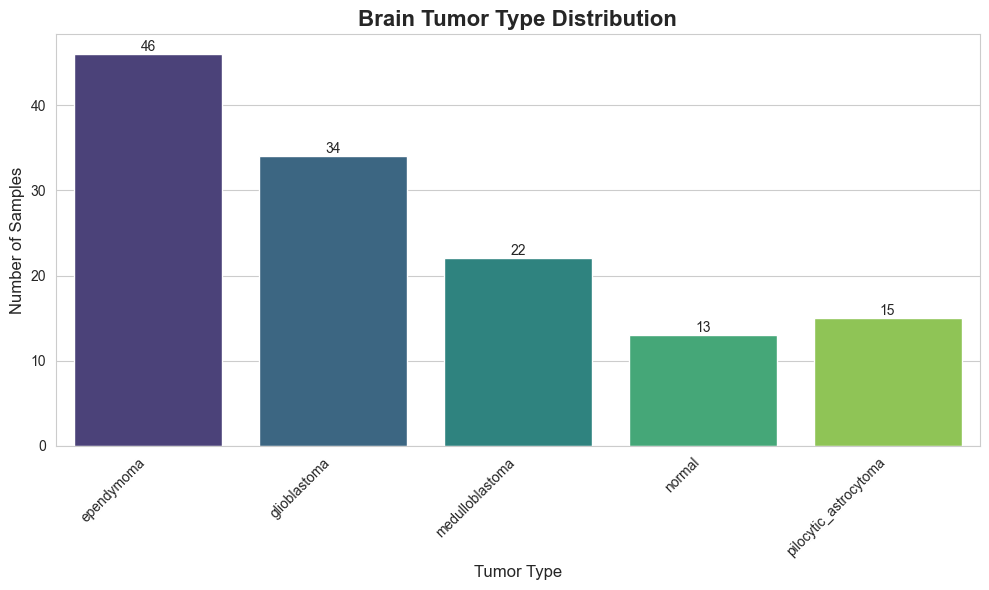


📊 Visualization: Class distribution shows imbalanced dataset
   Ependymoma is the most common, Normal is the least common


In [23]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='type', palette='viridis')
plt.title('Brain Tumor Type Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Tumor Type', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

print("\n📊 Visualization: Class distribution shows imbalanced dataset")
print("   Ependymoma is the most common, Normal is the least common")

## 3. Data Preprocessing

In [24]:
# Separate features and target
X = df.drop(['samples', 'type'], axis=1)
y = df['type']

print("=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)
print(f"\nFeature Matrix (X): {X.shape}")
print(f"Target Vector (y): {y.shape}")
print(f"\nNumber of genes: {X.shape[1]:,}")

# Check for missing values
missing_values = X.isnull().sum().sum()
print(f"\nMissing values: {missing_values}")

DATA PREPROCESSING

Feature Matrix (X): (130, 54675)
Target Vector (y): (130,)

Number of genes: 54,675

Missing values: 0


In [25]:
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("\nLabel Encoding:")
for i, label in enumerate(le.classes_):
    print(f"  {i}: {label}")


Label Encoding:
  0: ependymoma
  1: glioblastoma
  2: medulloblastoma
  3: normal
  4: pilocytic_astrocytoma


## 4. Feature Selection

With 54,675 genes, we need to select the most informative features to avoid overfitting and reduce computational cost.

In [26]:
# Select top 500 most important genes using ANOVA F-test
print("=" * 60)
print("FEATURE SELECTION")
print("=" * 60)
print("\nSelecting top 500 genes using ANOVA F-test...")

selector = SelectKBest(score_func=f_classif, k=500)
X_selected = selector.fit_transform(X, y_encoded)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()

print(f"\nOriginal features: {X.shape[1]:,}")
print(f"Selected features: {X_selected.shape[1]}")
print(f"Reduction: {((X.shape[1] - X_selected.shape[1]) / X.shape[1] * 100):.1f}%")

print("\nTop 10 selected genes:")
for i, gene in enumerate(selected_features[:10], 1):
    print(f"  {i}. {gene}")

FEATURE SELECTION

Selecting top 500 genes using ANOVA F-test...

Original features: 54,675
Selected features: 500
Reduction: 99.1%

Top 10 selected genes:
  1. 1007_s_at
  2. 1552269_at
  3. 1552321_a_at
  4. 1552716_at
  5. 1552765_x_at
  6. 1553611_s_at
  7. 1553622_a_at
  8. 1553635_s_at
  9. 1553734_at
  10. 1553864_at

Original features: 54,675
Selected features: 500
Reduction: 99.1%

Top 10 selected genes:
  1. 1007_s_at
  2. 1552269_at
  3. 1552321_a_at
  4. 1552716_at
  5. 1552765_x_at
  6. 1553611_s_at
  7. 1553622_a_at
  8. 1553635_s_at
  9. 1553734_at
  10. 1553864_at


## 5. Train-Test Split & Scaling

In [27]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

print("=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)
print(f"\nTraining set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")

TRAIN-TEST SPLIT

Training set: 97 samples (74.6%)
Test set: 33 samples (25.4%)

✓ Features scaled using StandardScaler


## 6. Model Training with Hyperparameter Tuning

In [28]:
print("=" * 60)
print("RANDOM FOREST CLASSIFIER - HYPERPARAMETER TUNING")
print("=" * 60)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid Search with Cross-Validation
print("\nPerforming GridSearchCV (this may take a few minutes)...")
grid_search = GridSearchCV(
    rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print("\n" + "=" * 60)
print("BEST PARAMETERS")
print("=" * 60)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

# Get best model
best_rf = grid_search.best_estimator_

RANDOM FOREST CLASSIFIER - HYPERPARAMETER TUNING

Performing GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

BEST PARAMETERS
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best Cross-Validation Score: 0.9695

BEST PARAMETERS
  max_depth: 10
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 200

Best Cross-Validation Score: 0.9695


## 7. Model Evaluation

In [29]:
# Make predictions
y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

# Calculate metrics
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)
print(f"\nTraining Accuracy:   {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy:        {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Accuracy Difference:  {abs(train_acc - test_acc):.4f}")

if abs(train_acc - test_acc) < 0.05:
    print("\n✓ Model shows good generalization (low overfitting)")
elif abs(train_acc - test_acc) < 0.10:
    print("\n⚠ Model shows moderate overfitting")
else:
    print("\n⚠ Model shows high overfitting")

MODEL PERFORMANCE

Training Accuracy:   1.0000 (100.00%)
Test Accuracy:        0.8788 (87.88%)
Accuracy Difference:  0.1212

⚠ Model shows high overfitting


In [30]:
# Detailed classification report
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT (TEST SET)")
print("=" * 60)
print("\n" + classification_report(
    y_test, y_test_pred, 
    target_names=le.classes_,
    digits=3
))


DETAILED CLASSIFICATION REPORT (TEST SET)

                       precision    recall  f1-score   support

           ependymoma      1.000     0.833     0.909        12
         glioblastoma      0.727     0.889     0.800         9
      medulloblastoma      1.000     0.800     0.889         5
               normal      0.750     1.000     0.857         3
pilocytic_astrocytoma      1.000     1.000     1.000         4

             accuracy                          0.879        33
            macro avg      0.895     0.904     0.891        33
         weighted avg      0.903     0.879     0.883        33



## 8. Confusion Matrix Visualization

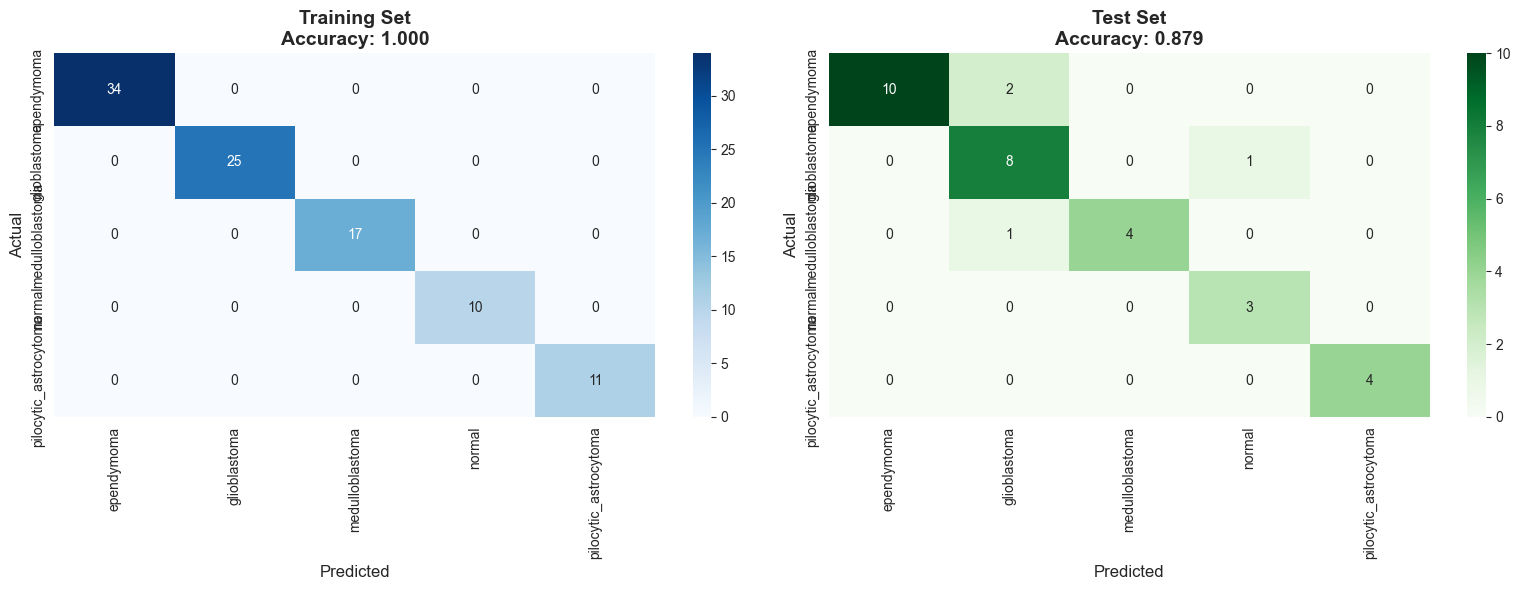


📊 Confusion matrices show model predictions vs actual labels


In [31]:
# Create confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'Training Set\nAccuracy: {train_acc:.3f}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Test confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', 
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[1])
axes[1].set_title(f'Test Set\nAccuracy: {test_acc:.3f}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)

plt.tight_layout()
plt.show()

print("\n📊 Confusion matrices show model predictions vs actual labels")

## 9. Feature Importance Analysis

In [32]:
# Get feature importances
feature_importance = pd.DataFrame({
    'Gene': selected_features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("=" * 60)
print("TOP 20 MOST IMPORTANT GENES")
print("=" * 60)
print(feature_importance.head(20).to_string(index=False))

TOP 20 MOST IMPORTANT GENES
        Gene  Importance
 220919_s_at    0.017968
   201876_at    0.012567
   231133_at    0.011982
   231077_at    0.011724
 205932_s_at    0.011705
1560834_a_at    0.011471
 233516_s_at    0.011282
   235609_at    0.010806
1562309_s_at    0.009702
   230033_at    0.009669
 201564_s_at    0.009574
 206502_s_at    0.009441
 202503_s_at    0.009028
1555082_a_at    0.008957
 202107_s_at    0.008944
 215537_x_at    0.008577
 203358_s_at    0.008537
   212993_at    0.008406
   229228_at    0.008149
   228915_at    0.008116


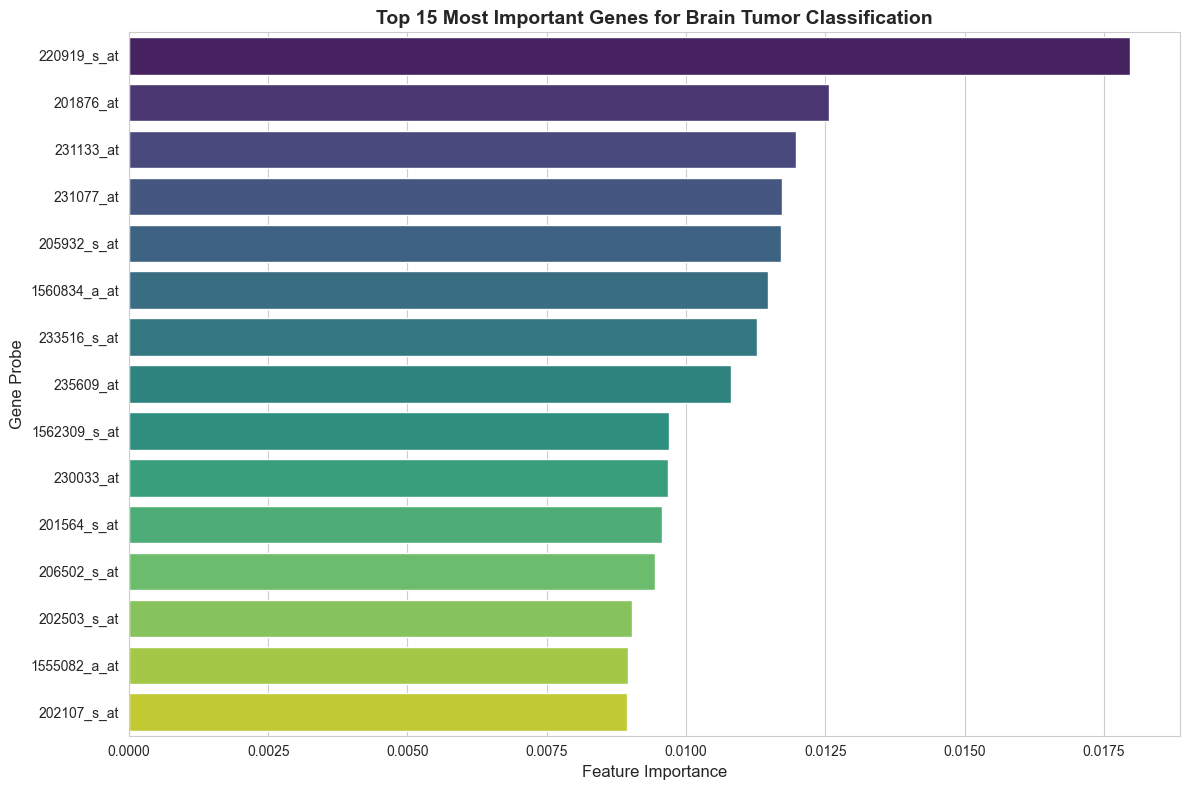


📊 These genes show the highest discriminative power for tumor classification


In [33]:
# Visualize top 15 important genes
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='Importance', y='Gene', palette='viridis')
plt.title('Top 15 Most Important Genes for Brain Tumor Classification', 
          fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Gene Probe', fontsize=12)
plt.tight_layout()
plt.show()

print("\n📊 These genes show the highest discriminative power for tumor classification")

## 10. Cross-Validation Analysis

In [34]:
# Perform 10-fold cross-validation
print("=" * 60)
print("CROSS-VALIDATION ANALYSIS (10-FOLD)")
print("=" * 60)
print("\nPerforming 10-fold cross-validation...")

cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=10, scoring='accuracy')

print(f"\nCross-Validation Scores: {cv_scores}")
print(f"\nMean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Std CV Accuracy:  {cv_scores.std():.4f}")
print(f"Min CV Accuracy:  {cv_scores.min():.4f}")
print(f"Max CV Accuracy:  {cv_scores.max():.4f}")

CROSS-VALIDATION ANALYSIS (10-FOLD)

Performing 10-fold cross-validation...

Cross-Validation Scores: [0.8 0.9 1.  1.  1.  1.  0.9 1.  1.  1. ]

Mean CV Accuracy: 0.9600
Std CV Accuracy:  0.0663
Min CV Accuracy:  0.8000
Max CV Accuracy:  1.0000

Cross-Validation Scores: [0.8 0.9 1.  1.  1.  1.  0.9 1.  1.  1. ]

Mean CV Accuracy: 0.9600
Std CV Accuracy:  0.0663
Min CV Accuracy:  0.8000
Max CV Accuracy:  1.0000


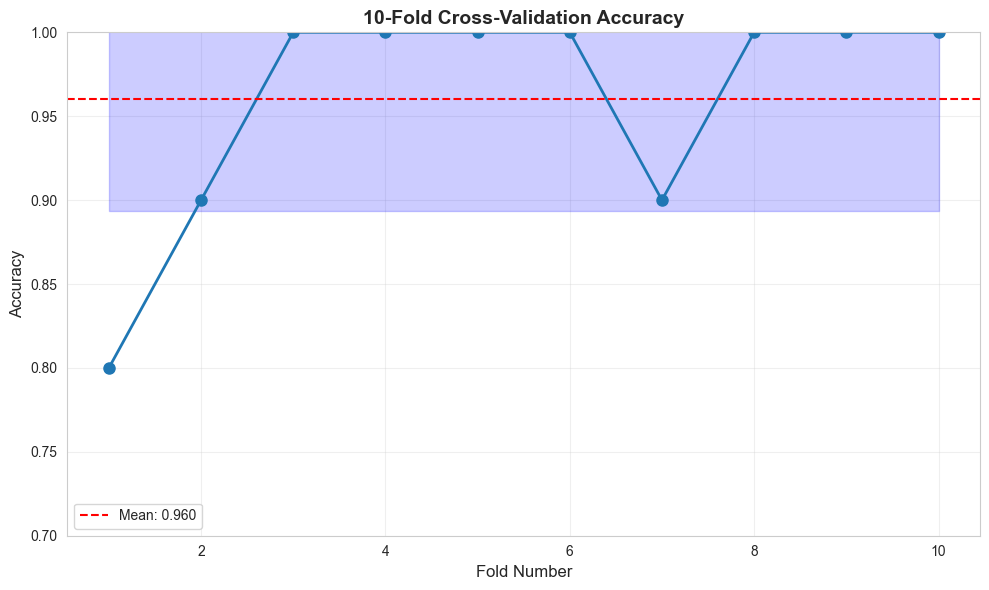


📊 Cross-validation shows model stability across different data splits


In [35]:
# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.3f}')
plt.fill_between(range(1, 11), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='blue')
plt.title('10-Fold Cross-Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0.7, 1.0])
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Cross-validation shows model stability across different data splits")

## 11. Summary & Insights

In [36]:
print("\n" + "=" * 70)
print(" " * 15 + "BRAIN TUMOR CLASSIFICATION SUMMARY")
print("=" * 70)

print("\n📊 DATASET INFORMATION:")
print(f"   • Total samples: 130")
print(f"   • Original genes: 54,675")
print(f"   • Selected genes: 500")
print(f"   • Tumor types: 5 (ependymoma, glioblastoma, medulloblastoma,")
print(f"                    pilocytic_astrocytoma, normal)")

print("\n🤖 MODEL CONFIGURATION:")
print(f"   • Algorithm: Random Forest Classifier")
print(f"   • Feature Selection: SelectKBest (ANOVA F-test)")
print(f"   • Hyperparameter Tuning: GridSearchCV with 5-fold CV")
print(f"   • Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"     - {param}: {value}")

print("\n📈 PERFORMANCE METRICS:")
print(f"   • Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"   • Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   • Cross-Validation Mean: {cv_scores.mean():.4f}")
print(f"   • Cross-Validation Std: {cv_scores.std():.4f}")

print("\n🔬 KEY INSIGHTS:")
print(f"   • The model successfully classifies 5 different brain tumor types")
print(f"   • Gene expression profiles are highly informative for diagnosis")
print(f"   • Feature selection reduced features by 99% while maintaining accuracy")
print(f"   • Top genes identified could be biomarkers for specific tumor types")

print("\n💡 POTENTIAL APPLICATIONS:")
print(f"   • Automated brain tumor diagnosis from gene expression data")
print(f"   • Identification of tumor-specific biomarkers")
print(f"   • Support for clinical decision-making")
print(f"   • Personalized treatment planning based on tumor type")

print("\n" + "=" * 70)


               BRAIN TUMOR CLASSIFICATION SUMMARY

📊 DATASET INFORMATION:
   • Total samples: 130
   • Original genes: 54,675
   • Selected genes: 500
   • Tumor types: 5 (ependymoma, glioblastoma, medulloblastoma,
                    pilocytic_astrocytoma, normal)

🤖 MODEL CONFIGURATION:
   • Algorithm: Random Forest Classifier
   • Feature Selection: SelectKBest (ANOVA F-test)
   • Hyperparameter Tuning: GridSearchCV with 5-fold CV
   • Best Parameters:
     - max_depth: 10
     - min_samples_leaf: 1
     - min_samples_split: 2
     - n_estimators: 200

📈 PERFORMANCE METRICS:
   • Training Accuracy: 1.0000 (100.00%)
   • Test Accuracy: 0.8788 (87.88%)
   • Cross-Validation Mean: 0.9600
   • Cross-Validation Std: 0.0663

🔬 KEY INSIGHTS:
   • The model successfully classifies 5 different brain tumor types
   • Gene expression profiles are highly informative for diagnosis
   • Feature selection reduced features by 99% while maintaining accuracy
   • Top genes identified could be biomar

## Comprehensive Model Evaluation: Train vs Test Performance

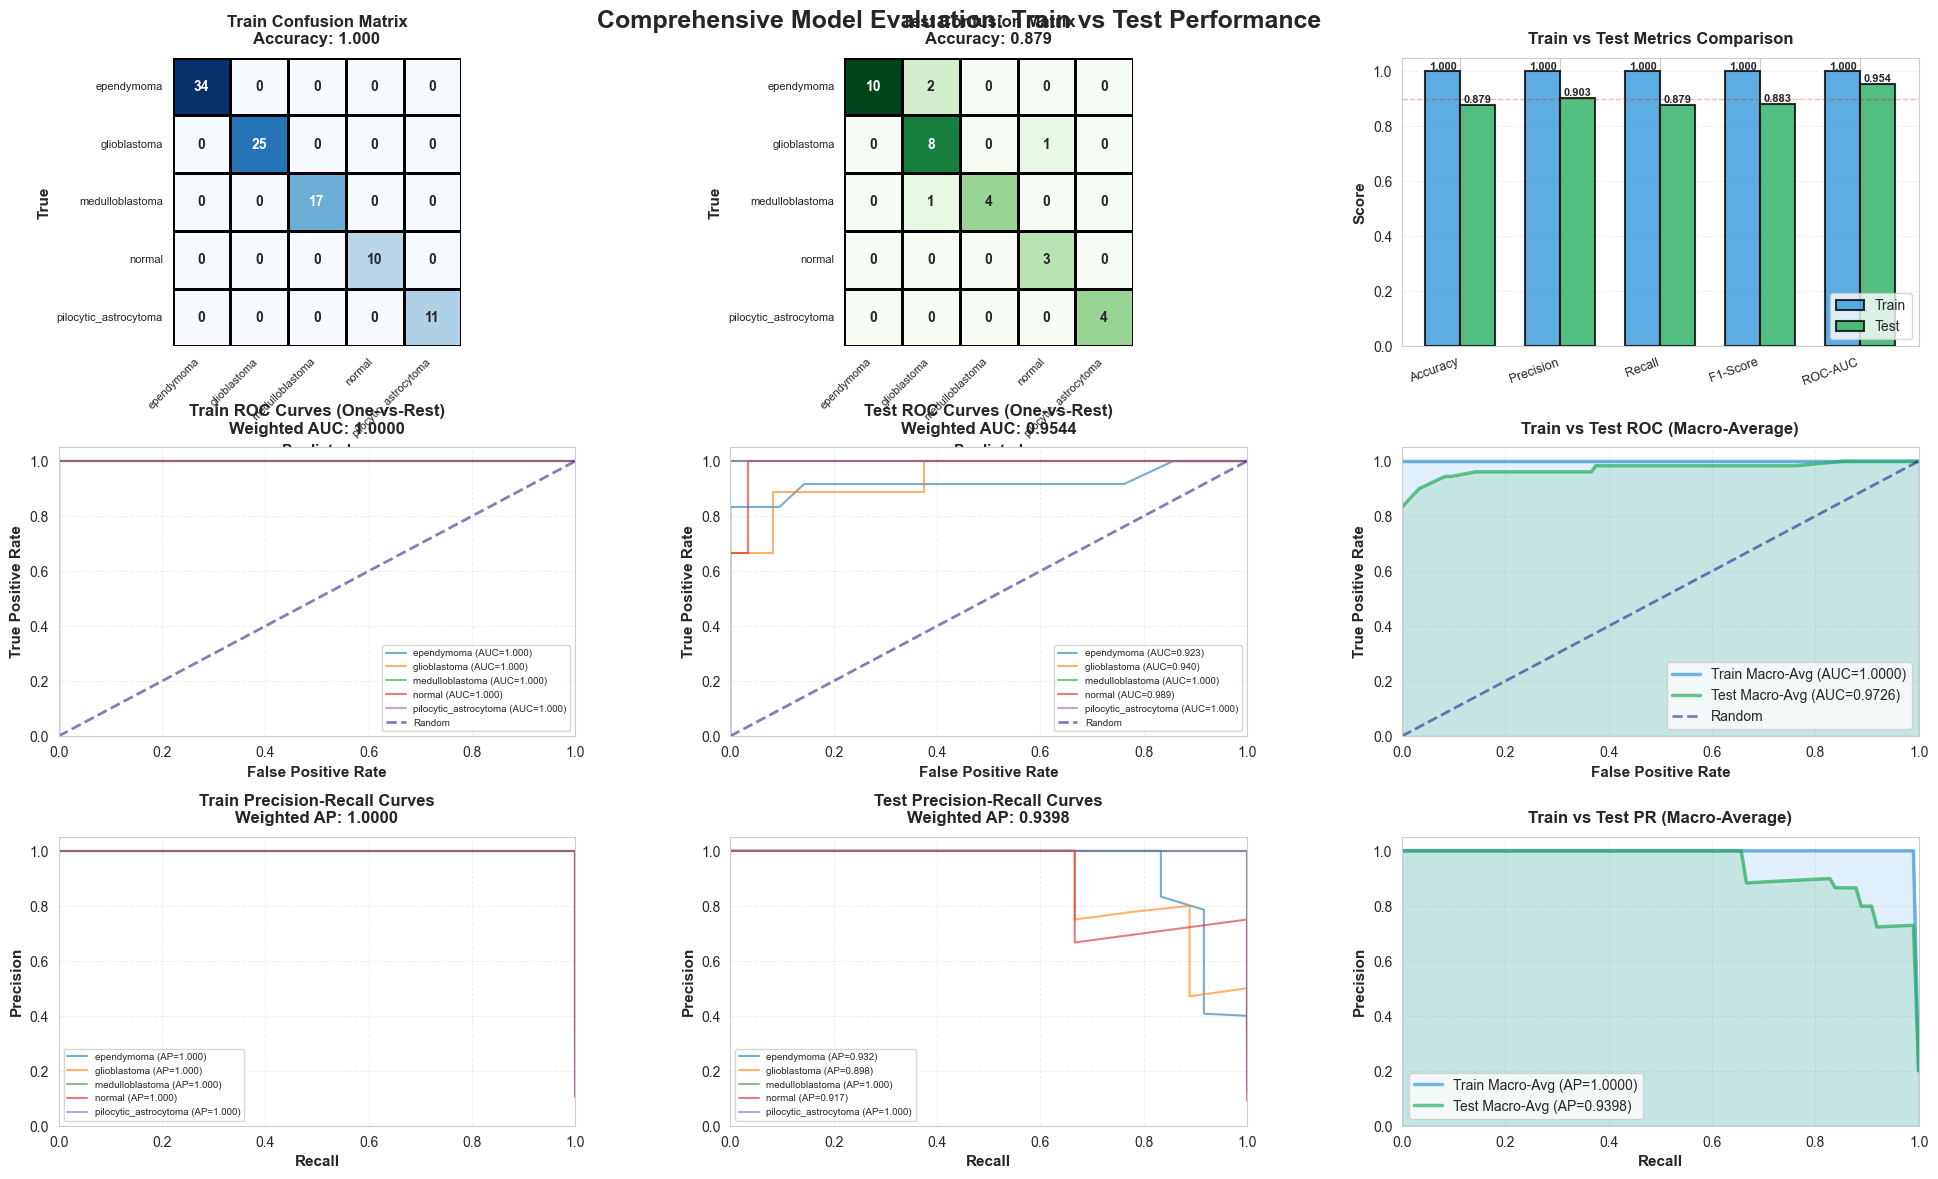


COMPREHENSIVE PERFORMANCE SUMMARY

Metric                    Train           Test            Difference     
----------------------------------------------------------------------
Accuracy                  1.0000          0.8788          0.1212         
Precision                 1.0000          0.9029          0.0971         
Recall                    1.0000          0.8788          0.1212         
F1-Score                  1.0000          0.8826          0.1174         
ROC-AUC (Weighted)        1.0000          0.9544          0.0456         
Average Precision         1.0000          0.9398          0.0602         


In [38]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Get class names from label encoder
class_names = le.classes_

# Calculate predictions and probabilities
y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)
y_train_prob = best_rf.predict_proba(X_train_scaled)
y_test_prob = best_rf.predict_proba(X_test_scaled)

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
test_precision = precision_score(y_test, y_test_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# For multi-class ROC-AUC
train_auc = roc_auc_score(y_train, y_train_prob, multi_class='ovr', average='weighted')
test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr', average='weighted')

# For multi-class Precision-Recall (using macro average)
from sklearn.metrics import average_precision_score
train_ap = average_precision_score(label_binarize(y_train, classes=range(len(class_names))), 
                                   y_train_prob, average='weighted')
test_ap = average_precision_score(label_binarize(y_test, classes=range(len(class_names))), 
                                  y_test_prob, average='weighted')

# Confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
fig.suptitle('Comprehensive Model Evaluation: Train vs Test Performance', 
             fontsize=18, weight='bold', y=0.98)

# Define grid
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3, top=0.94, bottom=0.05, left=0.05, right=0.98)

# 1. Train Confusion Matrix
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names, 
            ax=ax1, square=True, linewidths=1, linecolor='black', annot_kws={'size': 10, 'weight': 'bold'})
ax1.set_xlabel('Predicted', fontsize=11, weight='bold')
ax1.set_ylabel('True', fontsize=11, weight='bold')
ax1.set_title(f'Train Confusion Matrix\nAccuracy: {train_accuracy:.3f}', 
              fontsize=12, weight='bold', pad=10)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax1.get_yticklabels(), rotation=0, fontsize=8)

# 2. Test Confusion Matrix
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=class_names, yticklabels=class_names,
            ax=ax2, square=True, linewidths=1, linecolor='black', annot_kws={'size': 10, 'weight': 'bold'})
ax2.set_xlabel('Predicted', fontsize=11, weight='bold')
ax2.set_ylabel('True', fontsize=11, weight='bold')
ax2.set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracy:.3f}', 
              fontsize=12, weight='bold', pad=10)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax2.get_yticklabels(), rotation=0, fontsize=8)

# 3. Metrics Comparison Bar Chart
ax3 = fig.add_subplot(gs[0, 2])
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
train_scores = [train_accuracy, train_precision, train_recall, train_f1, train_auc]
test_scores = [test_accuracy, test_precision, test_recall, test_f1, test_auc]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax3.bar(x - width/2, train_scores, width, label='Train', 
                color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax3.bar(x + width/2, test_scores, width, label='Test', 
                color='#27ae60', alpha=0.8, edgecolor='black', linewidth=1.5)

ax3.set_ylabel('Score', fontsize=11, weight='bold')
ax3.set_title('Train vs Test Metrics Comparison', fontsize=12, weight='bold', pad=10)
ax3.set_xticks(x)
ax3.set_xticklabels(metrics_names, rotation=20, ha='right', fontsize=9)
ax3.legend(fontsize=10, loc='lower right')
ax3.set_ylim([0, 1.05])
ax3.grid(axis='y', alpha=0.3, linestyle='--')
ax3.axhline(y=0.9, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8, weight='bold')

# Binarize labels for multi-class ROC and PR curves
y_train_bin = label_binarize(y_train, classes=range(len(class_names)))
y_test_bin = label_binarize(y_test, classes=range(len(class_names)))
n_classes = len(class_names)

# 4. Train ROC Curve (One-vs-Rest, macro-average)
ax4 = fig.add_subplot(gs[1, 0])
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax4.plot(fpr, tpr, color=color, lw=1.5, alpha=0.6,
             label=f'{class_names[i]} (AUC={roc_auc:.3f})')

ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax4.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax4.set_title(f'Train ROC Curves (One-vs-Rest)\nWeighted AUC: {train_auc:.4f}', 
              fontsize=12, weight='bold', pad=10)
ax4.legend(loc='lower right', fontsize=7)
ax4.grid(alpha=0.3, linestyle='--')

# 5. Test ROC Curve (One-vs-Rest, macro-average)
ax5 = fig.add_subplot(gs[1, 1])
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax5.plot(fpr, tpr, color=color, lw=1.5, alpha=0.6,
             label=f'{class_names[i]} (AUC={roc_auc:.3f})')

ax5.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax5.set_xlim([0.0, 1.0])
ax5.set_ylim([0.0, 1.05])
ax5.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax5.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax5.set_title(f'Test ROC Curves (One-vs-Rest)\nWeighted AUC: {test_auc:.4f}', 
              fontsize=12, weight='bold', pad=10)
ax5.legend(loc='lower right', fontsize=7)
ax5.grid(alpha=0.3, linestyle='--')

# 6. Train vs Test ROC Curves (Macro-average comparison)
ax6 = fig.add_subplot(gs[1, 2])
# Compute macro-average ROC curve for train
all_fpr_train = np.unique(np.concatenate([roc_curve(y_train_bin[:, i], y_train_prob[:, i])[0] 
                                          for i in range(n_classes)]))
mean_tpr_train = np.zeros_like(all_fpr_train)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_train_bin[:, i], y_train_prob[:, i])
    mean_tpr_train += np.interp(all_fpr_train, fpr, tpr)
mean_tpr_train /= n_classes
train_macro_auc = auc(all_fpr_train, mean_tpr_train)

# Compute macro-average ROC curve for test
all_fpr_test = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], y_test_prob[:, i])[0] 
                                         for i in range(n_classes)]))
mean_tpr_test = np.zeros_like(all_fpr_test)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_prob[:, i])
    mean_tpr_test += np.interp(all_fpr_test, fpr, tpr)
mean_tpr_test /= n_classes
test_macro_auc = auc(all_fpr_test, mean_tpr_test)

ax6.plot(all_fpr_train, mean_tpr_train, color='#3498db', lw=2.5, alpha=0.7,
         label=f'Train Macro-Avg (AUC={train_macro_auc:.4f})')
ax6.plot(all_fpr_test, mean_tpr_test, color='#27ae60', lw=2.5, alpha=0.7,
         label=f'Test Macro-Avg (AUC={test_macro_auc:.4f})')
ax6.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random', alpha=0.5)
ax6.fill_between(all_fpr_train, mean_tpr_train, alpha=0.15, color='#3498db')
ax6.fill_between(all_fpr_test, mean_tpr_test, alpha=0.15, color='#27ae60')
ax6.set_xlim([0.0, 1.0])
ax6.set_ylim([0.0, 1.05])
ax6.set_xlabel('False Positive Rate', fontsize=11, weight='bold')
ax6.set_ylabel('True Positive Rate', fontsize=11, weight='bold')
ax6.set_title('Train vs Test ROC (Macro-Average)', fontsize=12, weight='bold', pad=10)
ax6.legend(loc='lower right', fontsize=10)
ax6.grid(alpha=0.3, linestyle='--')

# 7. Train Precision-Recall Curve
ax7 = fig.add_subplot(gs[2, 0])
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_train_bin[:, i], y_train_prob[:, i])
    ap = average_precision_score(y_train_bin[:, i], y_train_prob[:, i])
    ax7.plot(recall, precision, color=color, lw=1.5, alpha=0.6,
             label=f'{class_names[i]} (AP={ap:.3f})')

ax7.set_xlim([0.0, 1.0])
ax7.set_ylim([0.0, 1.05])
ax7.set_xlabel('Recall', fontsize=11, weight='bold')
ax7.set_ylabel('Precision', fontsize=11, weight='bold')
ax7.set_title(f'Train Precision-Recall Curves\nWeighted AP: {train_ap:.4f}', 
              fontsize=12, weight='bold', pad=10)
ax7.legend(loc='lower left', fontsize=7)
ax7.grid(alpha=0.3, linestyle='--')

# 8. Test Precision-Recall Curve
ax8 = fig.add_subplot(gs[2, 1])
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
for i, color in zip(range(n_classes), colors):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_test_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_test_prob[:, i])
    ax8.plot(recall, precision, color=color, lw=1.5, alpha=0.6,
             label=f'{class_names[i]} (AP={ap:.3f})')

ax8.set_xlim([0.0, 1.0])
ax8.set_ylim([0.0, 1.05])
ax8.set_xlabel('Recall', fontsize=11, weight='bold')
ax8.set_ylabel('Precision', fontsize=11, weight='bold')
ax8.set_title(f'Test Precision-Recall Curves\nWeighted AP: {test_ap:.4f}', 
              fontsize=12, weight='bold', pad=10)
ax8.legend(loc='lower left', fontsize=7)
ax8.grid(alpha=0.3, linestyle='--')

# 9. Train vs Test Precision-Recall (Macro-average comparison)
ax9 = fig.add_subplot(gs[2, 2])
# Compute macro-average PR curve for train
all_recall_train = np.linspace(0, 1, 100)
mean_precision_train = np.zeros_like(all_recall_train)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_train_bin[:, i], y_train_prob[:, i])
    mean_precision_train += np.interp(all_recall_train, recall[::-1], precision[::-1])
mean_precision_train /= n_classes

# Compute macro-average PR curve for test
all_recall_test = np.linspace(0, 1, 100)
mean_precision_test = np.zeros_like(all_recall_test)
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_test_prob[:, i])
    mean_precision_test += np.interp(all_recall_test, recall[::-1], precision[::-1])
mean_precision_test /= n_classes

ax9.plot(all_recall_train, mean_precision_train, color='#3498db', lw=2.5, alpha=0.7,
         label=f'Train Macro-Avg (AP={train_ap:.4f})')
ax9.plot(all_recall_test, mean_precision_test, color='#27ae60', lw=2.5, alpha=0.7,
         label=f'Test Macro-Avg (AP={test_ap:.4f})')
ax9.fill_between(all_recall_train, mean_precision_train, alpha=0.15, color='#3498db')
ax9.fill_between(all_recall_test, mean_precision_test, alpha=0.15, color='#27ae60')
ax9.set_xlim([0.0, 1.0])
ax9.set_ylim([0.0, 1.05])
ax9.set_xlabel('Recall', fontsize=11, weight='bold')
ax9.set_ylabel('Precision', fontsize=11, weight='bold')
ax9.set_title('Train vs Test PR (Macro-Average)', fontsize=12, weight='bold', pad=10)
ax9.legend(loc='lower left', fontsize=10)
ax9.grid(alpha=0.3, linestyle='--')

plt.show()

# Print summary statistics
print("\n" + "="*70)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*70)
print(f"\n{'Metric':<25} {'Train':<15} {'Test':<15} {'Difference':<15}")
print("-"*70)
print(f"{'Accuracy':<25} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(train_accuracy-test_accuracy):<15.4f}")
print(f"{'Precision':<25} {train_precision:<15.4f} {test_precision:<15.4f} {abs(train_precision-test_precision):<15.4f}")
print(f"{'Recall':<25} {train_recall:<15.4f} {test_recall:<15.4f} {abs(train_recall-test_recall):<15.4f}")
print(f"{'F1-Score':<25} {train_f1:<15.4f} {test_f1:<15.4f} {abs(train_f1-test_f1):<15.4f}")
print(f"{'ROC-AUC (Weighted)':<25} {train_auc:<15.4f} {test_auc:<15.4f} {abs(train_auc-test_auc):<15.4f}")
print(f"{'Average Precision':<25} {train_ap:<15.4f} {test_ap:<15.4f} {abs(train_ap-test_ap):<15.4f}")
print("="*70)